AI PATHFINDER
1. BFS
2. DFS
3. UCS
4. DLS
5. IDDFS
6. Bidirectional
0. Exit


Enter your choice:  1


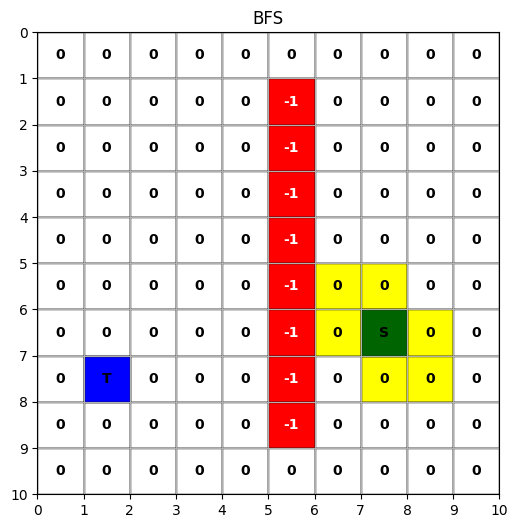

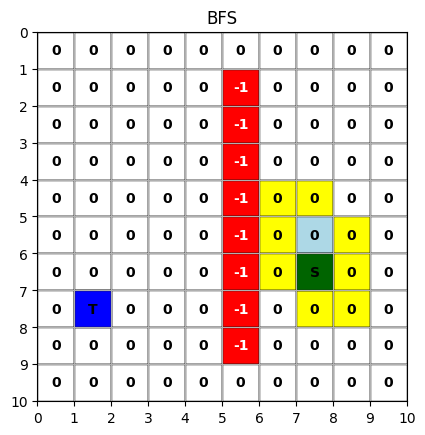

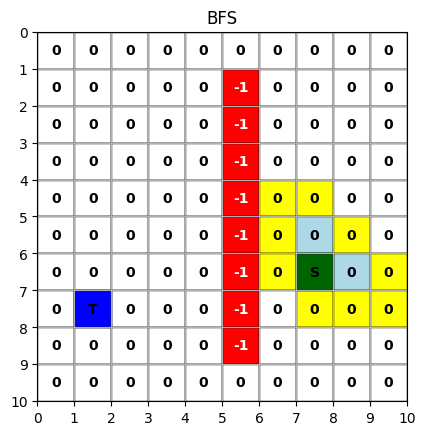

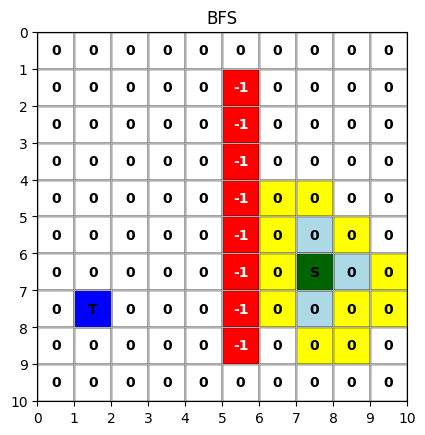

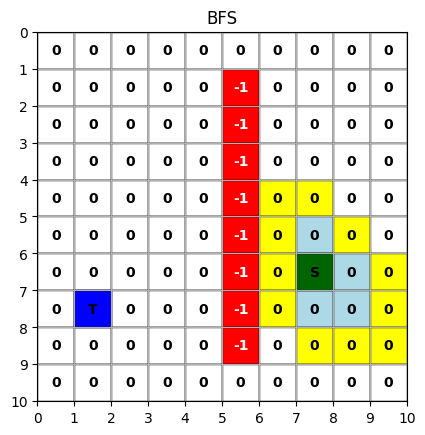

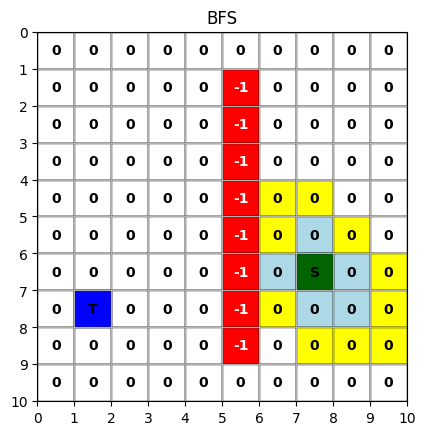

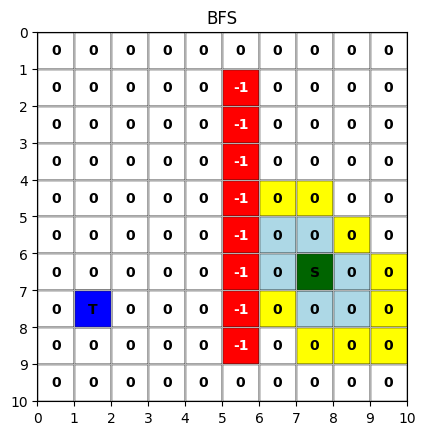

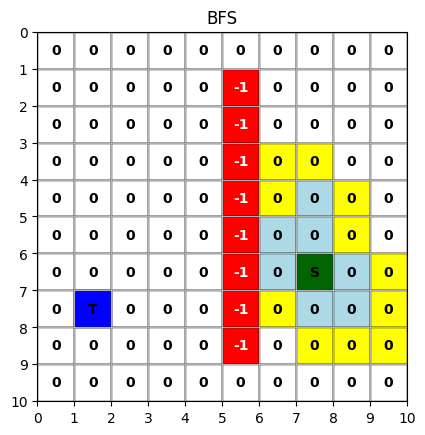

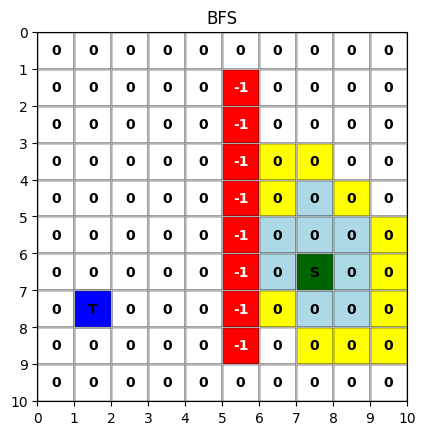

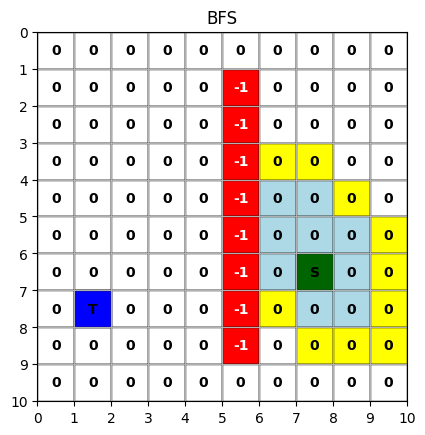

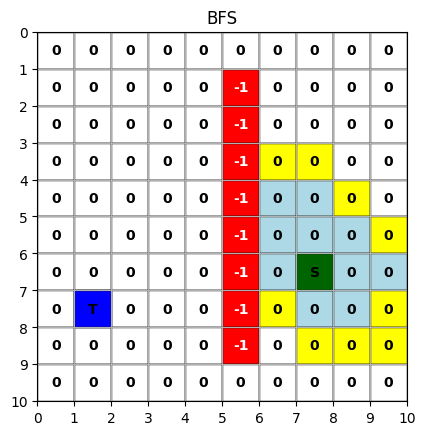

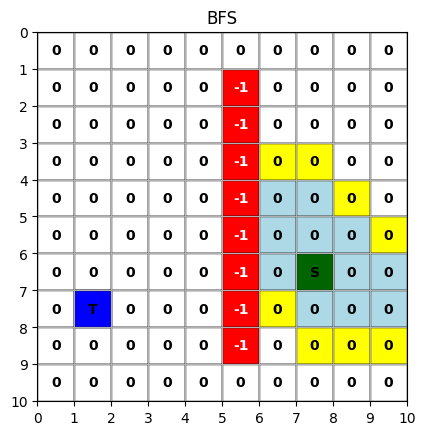

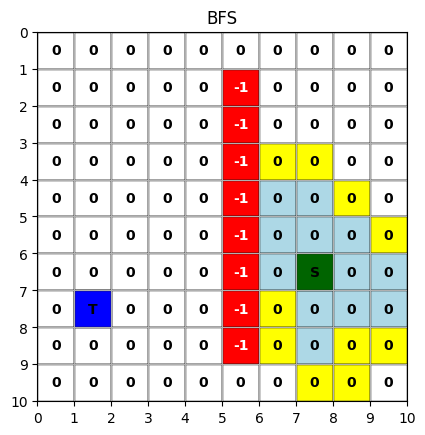

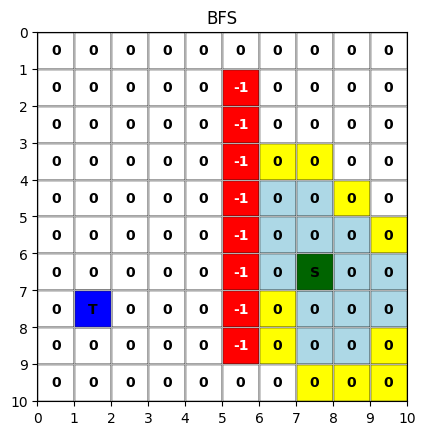

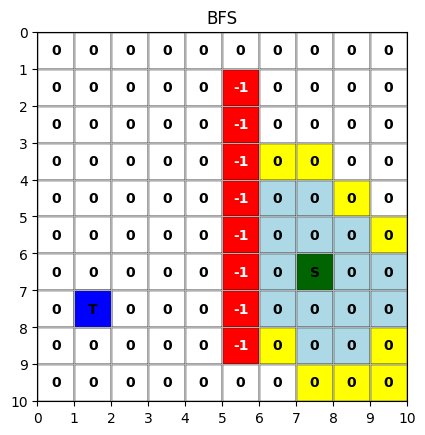

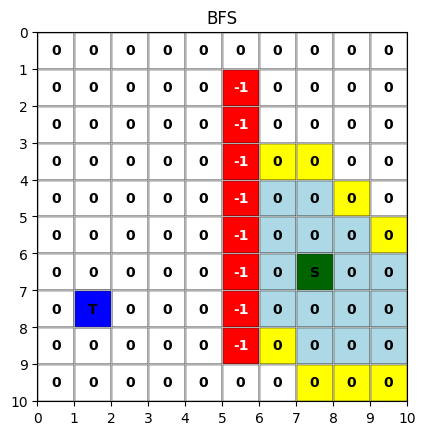

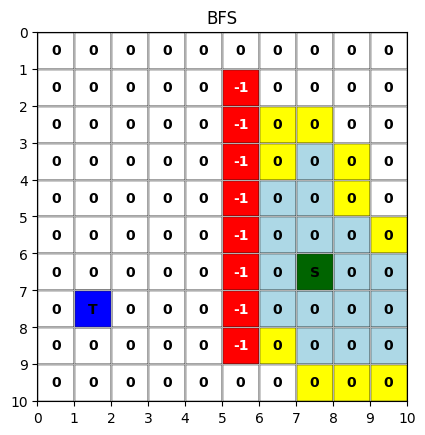

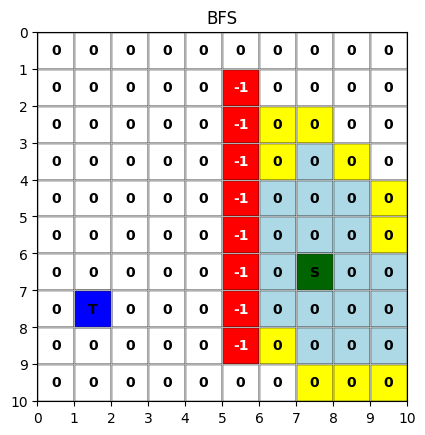

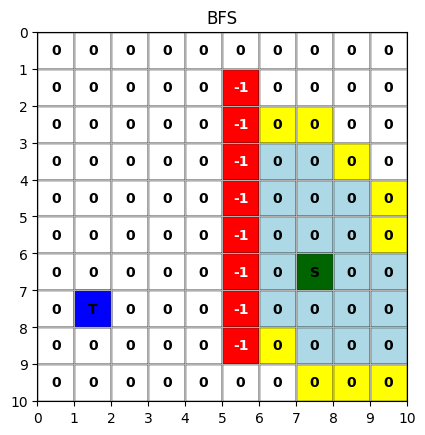

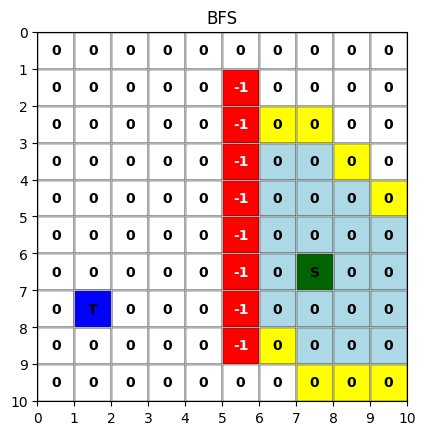

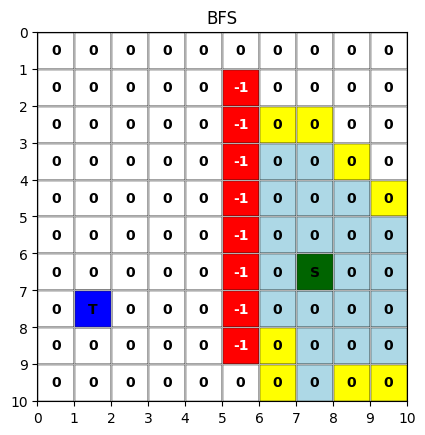

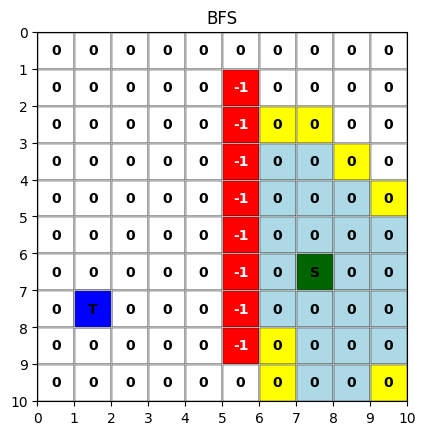

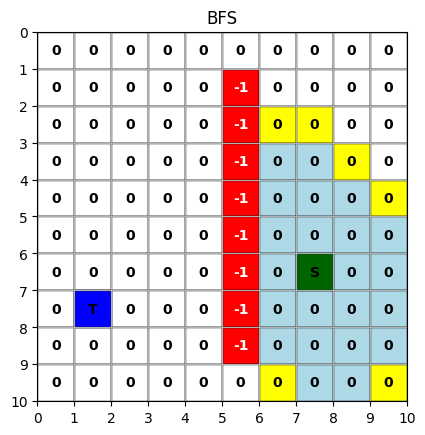

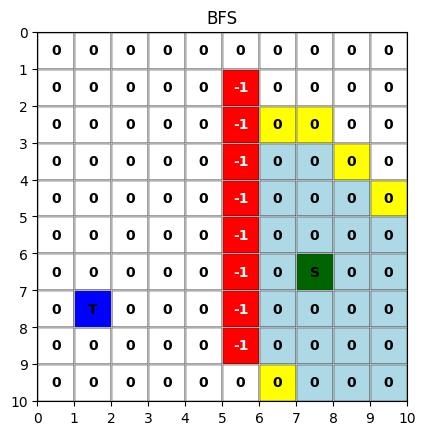

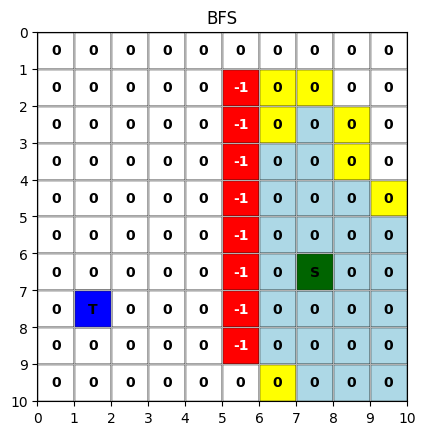

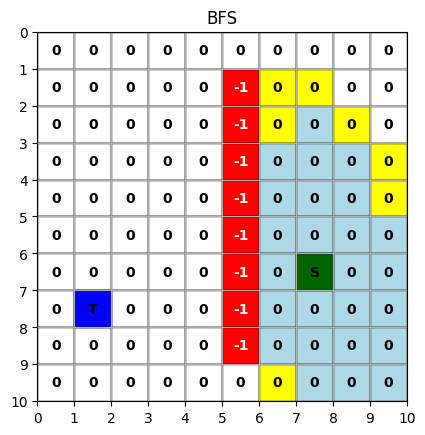

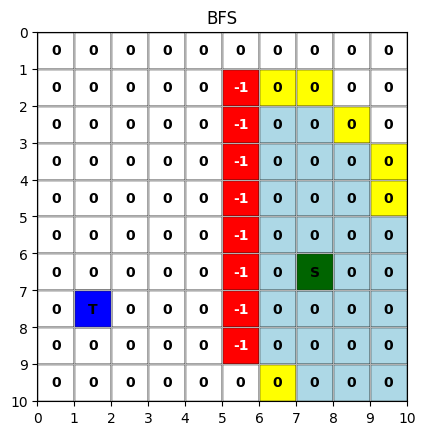

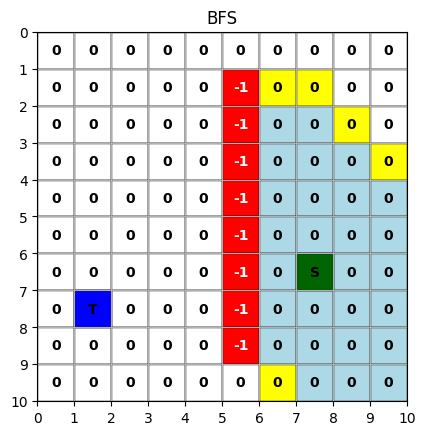

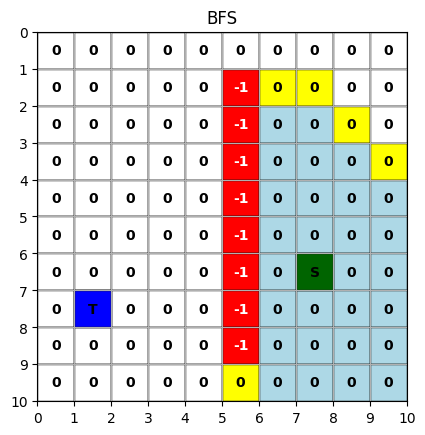

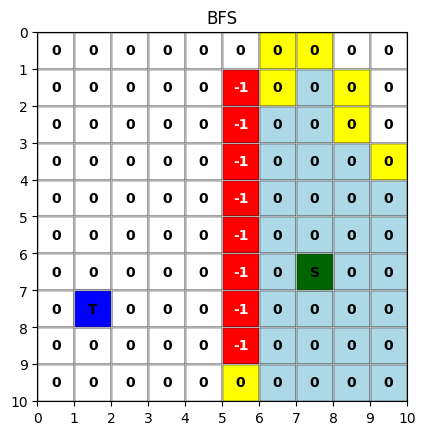

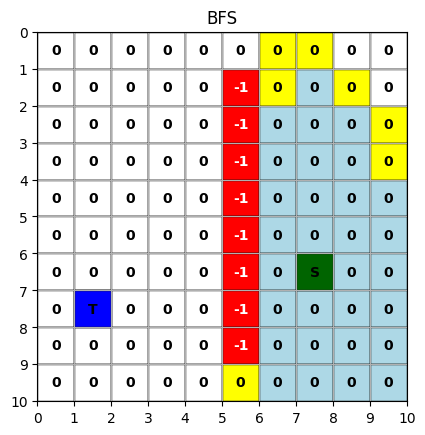

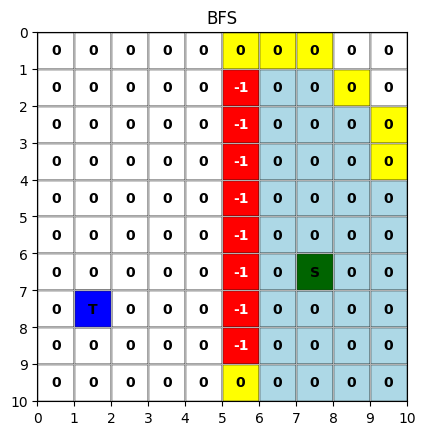

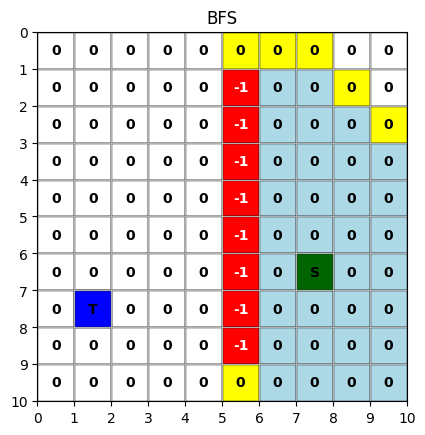

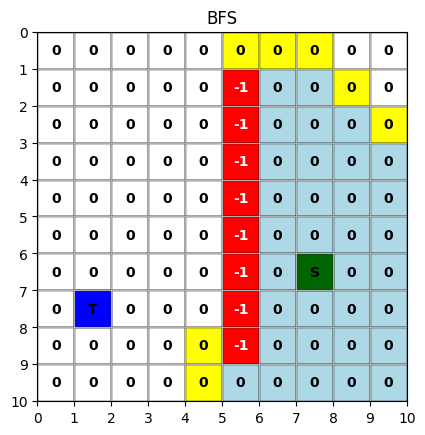

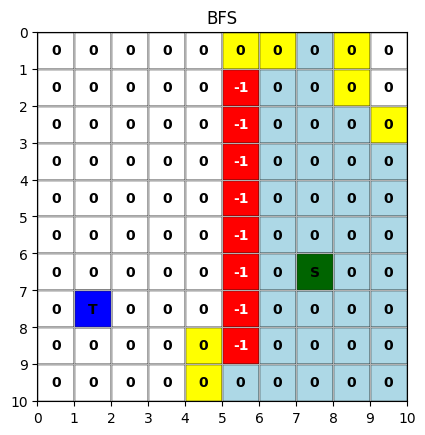

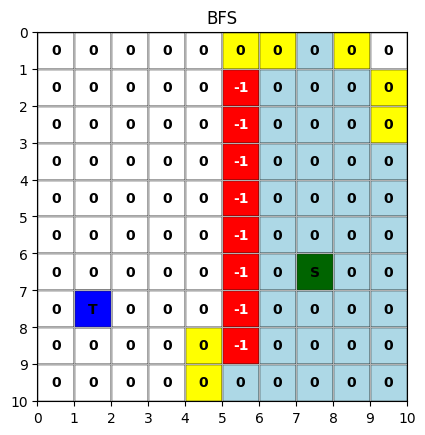

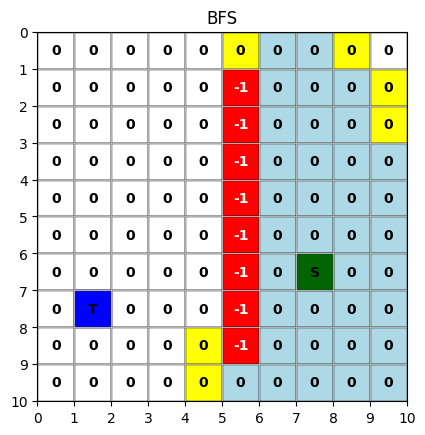

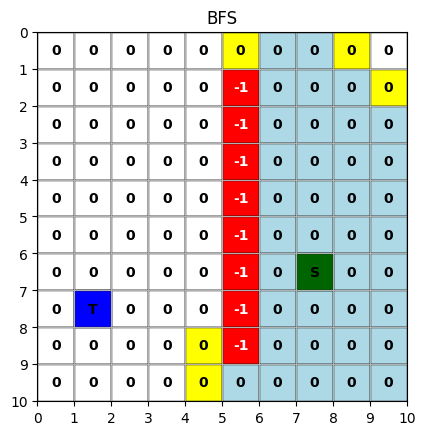

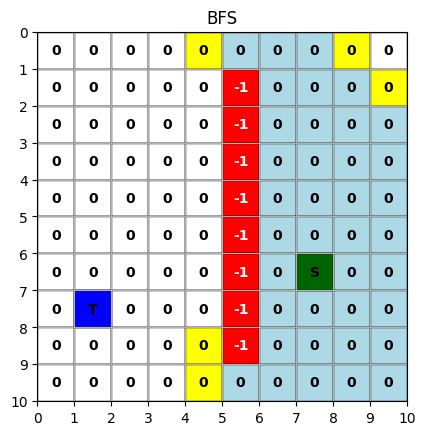

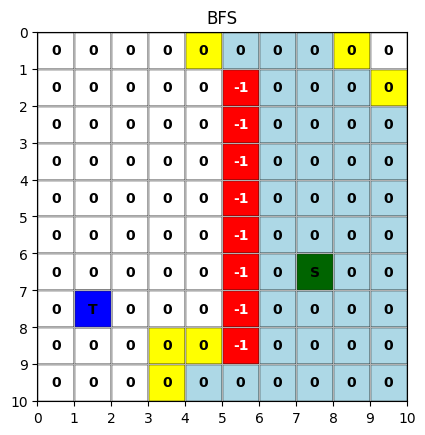

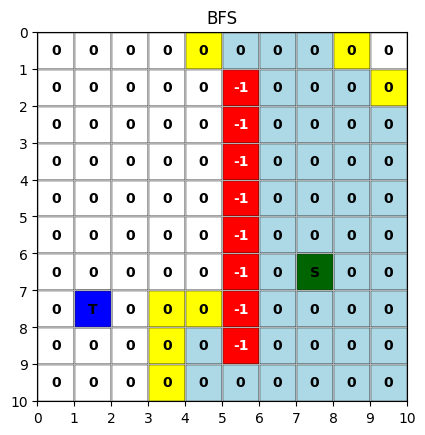

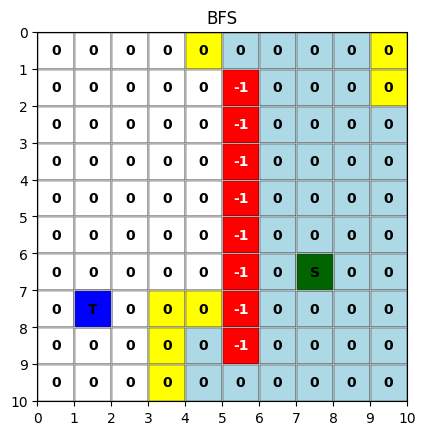

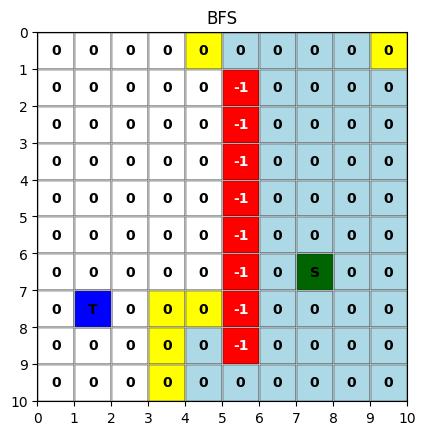

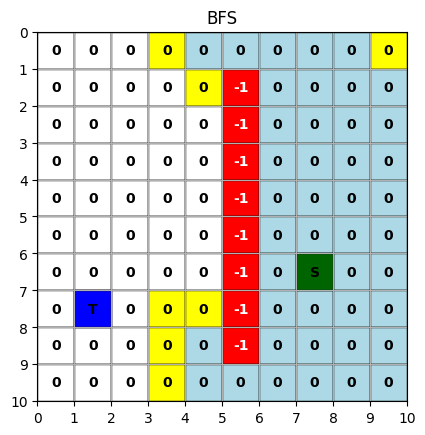

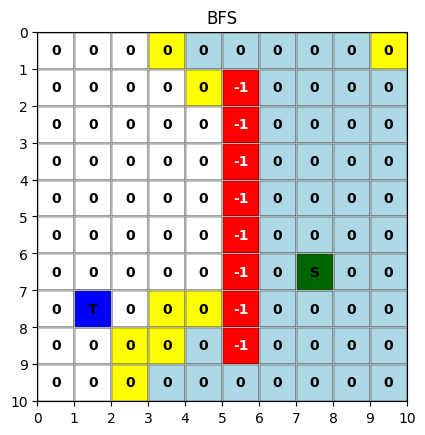

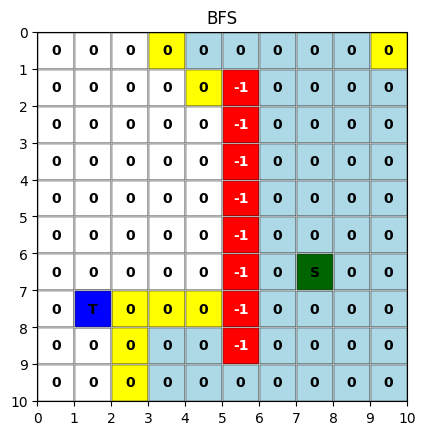

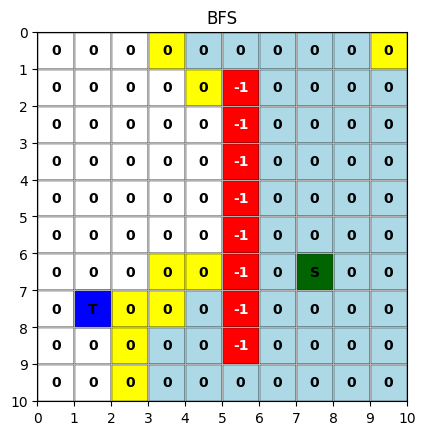

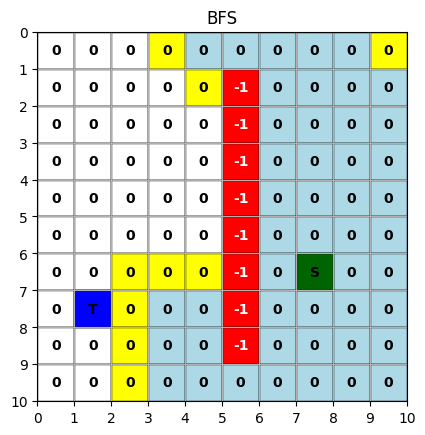

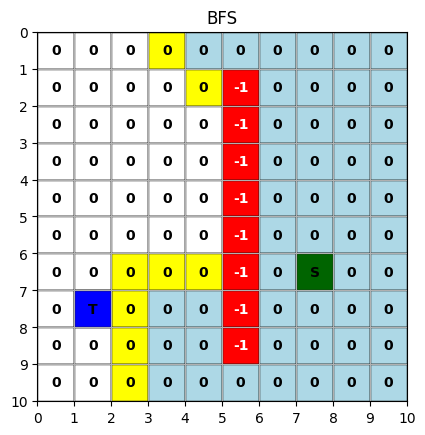

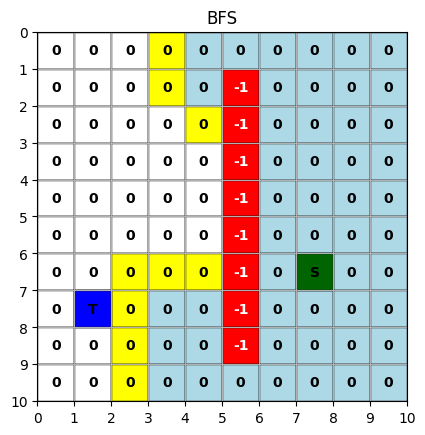

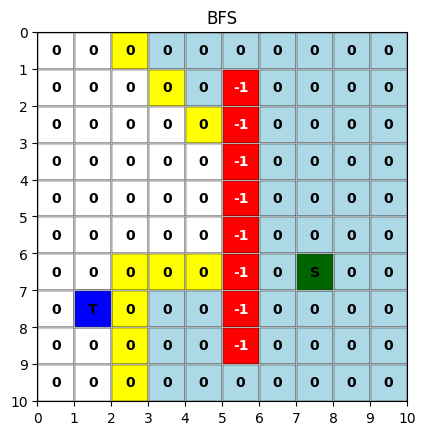

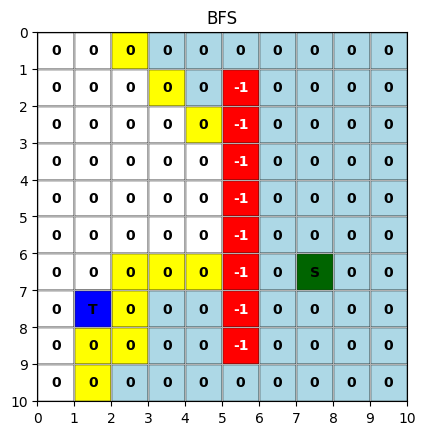

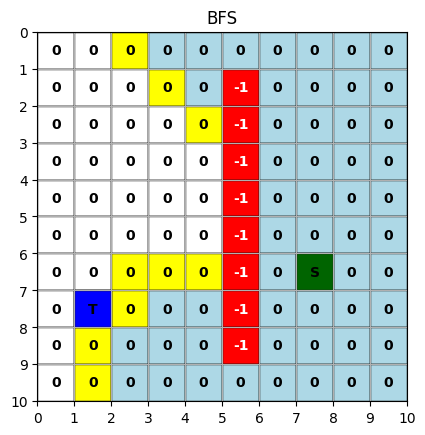

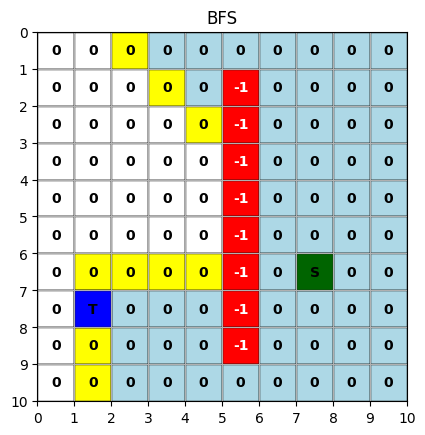

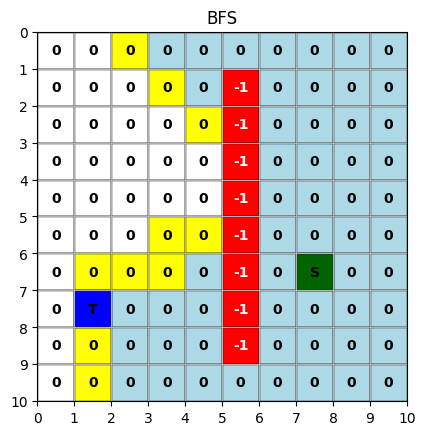

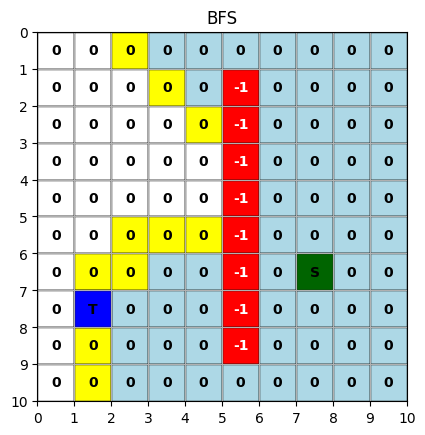

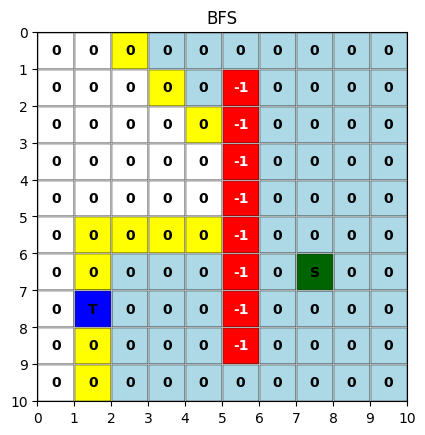

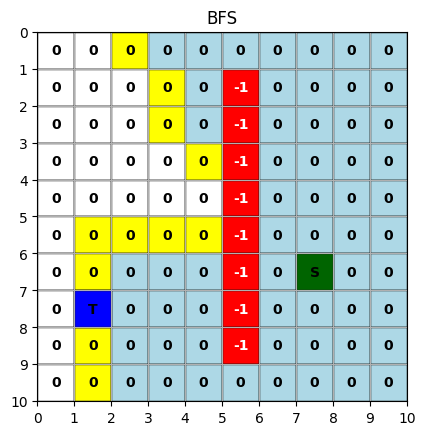

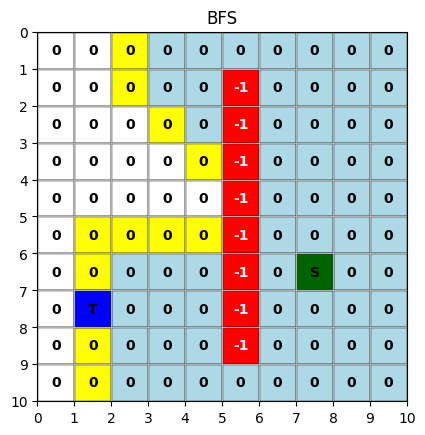

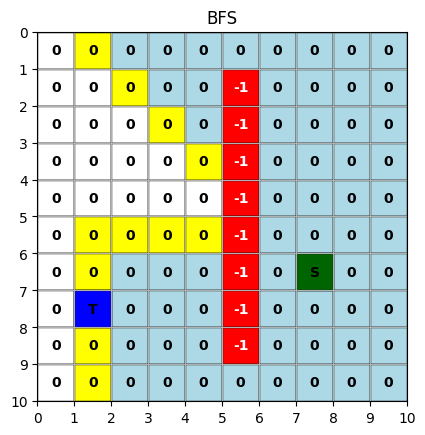

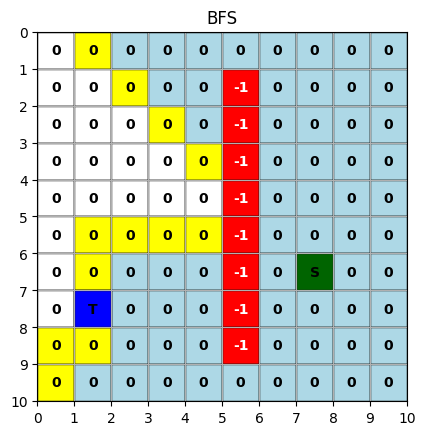

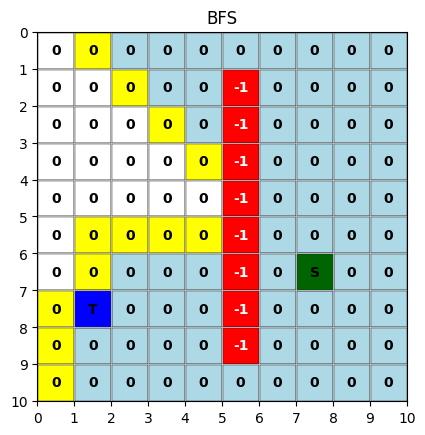

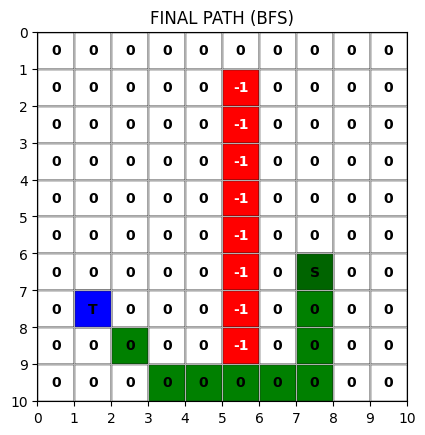

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
from collections import deque

ROWS, COLS = 10, 10
DELAY = 0.25


MOVES = [
    (-1, 0),   # Up
    (0, 1),    # Right
    (1, 0),    # Bottom
    (1, 1),    # Bottom-Right
    (0, -1),   # Left
    (-1, -1)   # Top-Left
]

def create_grid():
    grid = np.zeros((ROWS, COLS), dtype=int)
    # Vertical wall
    for r in range(1, ROWS-1):
        grid[r][5] = -1
    return grid

def in_bounds(r, c):
    return 0 <= r < ROWS and 0 <= c < COLS

def get_neighbors(node, grid):
    r, c = node
    nbrs = []
    for dr, dc in MOVES:
        nr, nc = r + dr, c + dc
        if in_bounds(nr, nc) and grid[nr][nc] != -1:
            nbrs.append((nr, nc))
    return nbrs

def draw_grid(grid, start, goal, frontier, explored, path, title="Search"):
    plt.clf()
    ax = plt.gca()
    ax.set_aspect('equal')

    for r in range(ROWS):
        for c in range(COLS):
            color = "white"  
            text = str(grid[r][c])  

            if grid[r][c] == -1:
                color = "red"
                text = "-1"
            if (r, c) in frontier:
                color = "yellow"
            if (r, c) in explored:
                color = "lightblue"
            if (r, c) in path:
                color = "green"

            ax.add_patch(plt.Rectangle((c, r), 1, 1, facecolor=color, edgecolor='black'))

            # Draw numbers inside cells
            if (r, c) == start:
                text = "S"
            elif (r, c) == goal:
                text = "T"

            ax.text(c + 0.5, r + 0.5, text, ha="center", va="center", fontsize=10, weight="bold",
                    color="white" if color in ["red", "darkgreen", "blue"] else "black")

    sr, sc = start
    gr, gc = goal
    ax.add_patch(plt.Rectangle((sc, sr), 1, 1, facecolor="darkgreen", edgecolor='black'))
    ax.add_patch(plt.Rectangle((gc, gr), 1, 1, facecolor="blue", edgecolor='black'))

    ax.set_xlim(0, COLS)
    ax.set_ylim(0, ROWS)
    ax.set_xticks(range(COLS+1))
    ax.set_yticks(range(ROWS+1))
    ax.invert_yaxis()
    ax.grid(True)
    ax.set_title(title)
    plt.pause(DELAY)


def build_path(parent, start, goal):
    path = []
    node = goal
    while node is not None:
        path.append(node)
        node = parent.get(node)
    path.reverse()
    return path


def bfs(grid, start, goal):
    queue = deque([start])
    visited = {start}
    parent = {start: None}
    frontier = {start}
    explored = set()

    while queue:
        node = queue.popleft()
        frontier.discard(node)
        explored.add(node)

        if node == goal:
            return build_path(parent, start, goal)

        for nbr in get_neighbors(node, grid):
            if nbr not in visited:
                visited.add(nbr)
                parent[nbr] = node
                queue.append(nbr)
                frontier.add(nbr)

        draw_grid(grid, start, goal, frontier, explored, [], "BFS")
    return None

def dfs(grid, start, goal):
    stack = [start]
    visited = set()
    parent = {start: None}
    frontier = {start}
    explored = set()

    while stack:
        node = stack.pop()
        frontier.discard(node)

        if node == goal:
            return build_path(parent, start, goal)

        if node not in visited:
            visited.add(node)
            explored.add(node)

            for nbr in get_neighbors(node, grid):
                if nbr not in visited:
                    parent[nbr] = node
                    stack.append(nbr)
                    frontier.add(nbr)

        draw_grid(grid, start, goal, frontier, explored, [], "DFS")
    return None

def ucs(grid, start, goal):
    pq = [(0, start)]
    best = {start: 0}
    parent = {start: None}
    frontier = {start}
    explored = set()

    while pq:
        cost, node = heapq.heappop(pq)
        frontier.discard(node)
        explored.add(node)

        if node == goal:
            return build_path(parent, start, goal)

        for nbr in get_neighbors(node, grid):
            new_cost = cost + 1
            if new_cost < best.get(nbr, float("inf")):
                best[nbr] = new_cost
                parent[nbr] = node
                heapq.heappush(pq, (new_cost, nbr))
                frontier.add(nbr)

        draw_grid(grid, start, goal, frontier, explored, [], "UCS")
    return None

def dls(grid, start, goal, limit=10, title="DLS"):
    parent = {start: None}
    visited = set()
    explored = set()

    def dfs_limit(node, depth):
        frontier = {node}
        explored.add(node)
        if node == goal:
            return True
        if depth == limit:
            return False

        visited.add(node)
        for nbr in get_neighbors(node, grid):
            if nbr not in visited:
                parent[nbr] = node
                if dfs_limit(nbr, depth+1):
                    return True
        draw_grid(grid, start, goal, frontier, explored, [], f"{title} (limit={limit})")
        return False

    found = dfs_limit(start, 0)
    if found:
        return build_path(parent, start, goal)
    return None

def iddfs(grid, start, goal, max_depth=15):
    for depth in range(max_depth):
        path = dls(grid, start, goal, limit=depth, title="IDDFS")
        if path:
            return path
    return None

def bidirectional_search(grid, start, goal):
    if start == goal:
        return [start]

    q_f, q_b = deque([start]), deque([goal])
    visited_f, visited_b = {start}, {goal}
    parent_f, parent_b = {start: None}, {goal: None}

    while q_f and q_b:
        for _ in range(len(q_f)):
            current = q_f.popleft()
            for nbr in get_neighbors(current, grid):
                if nbr not in visited_f:
                    visited_f.add(nbr)
                    parent_f[nbr] = current
                    q_f.append(nbr)
                    if nbr in visited_b:
                        return build_bidirectional_path(parent_f, parent_b, nbr)

        for _ in range(len(q_b)):
            current = q_b.popleft()
            for nbr in get_neighbors(current, grid):
                if nbr not in visited_b:
                    visited_b.add(nbr)
                    parent_b[nbr] = current
                    q_b.append(nbr)
                    if nbr in visited_f:
                        return build_bidirectional_path(parent_f, parent_b, nbr)

        frontier = set(q_f) | set(q_b)
        explored = visited_f | visited_b
        draw_grid(grid, start, goal, frontier, explored, [], "Bidirectional BFS")

    return None

def build_bidirectional_path(parent_f, parent_b, meet):
    path_f, node = [], meet
    while node is not None:
        path_f.append(node)
        node = parent_f[node]
    path_f.reverse()

    path_b, node = [], parent_b[meet]
    while node is not None:
        path_b.append(node)
        node = parent_b[node]

    return path_f + path_b

def run(algo="bfs"):
    grid = create_grid()
    start, goal = (6,7), (7,1)
    plt.figure(figsize=(6,6))

    if algo=="bfs": 
        path=bfs(grid,start,goal)
    elif algo=="dfs":
        path=dfs(grid,start,goal)
    elif algo=="ucs": 
        path=ucs(grid,start,goal)
    elif algo=="dls": 
        path=dls(grid,start,goal,limit=20)
    elif algo=="iddfs": 
        path=iddfs(grid,start,goal,max_depth=15)
    elif algo=="bi": 
        path=bidirectional_search(grid,start,goal)
    else: return

    if path: draw_grid(grid,start,goal,[],[],path,f"FINAL PATH ({algo.upper()})")
    plt.show()

def menu():
    print("AI PATHFINDER")
    print("1. BFS\n2. DFS\n3. UCS\n4. DLS\n5. IDDFS\n6. Bidirectional\n0. Exit")
    choice = input("Enter your choice: ")
    if choice=="1": 
        run("bfs")
    elif choice=="2":
        run("dfs")
    elif choice=="3": 
        run("ucs")
    elif choice=="4":
        run("dls")
    elif choice=="5": 
        run("iddfs")
    elif choice=="6": 
        run("bi")
    elif choice=="0": 
        return

menu()
